# Replicating March 1991

James Houghton

In [1]:
%pylab inline
import numpy as np
from scipy.stats import mode
import numba as nb

Populating the interactive namespace from numpy and matplotlib


There is an external reality that is independent of beliefs about it. Reality is
described as having m dimensions, each of which has a value of 1 or -1. The
(independent) probability that any one dimension will have a value of 1is 0.5.

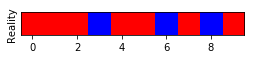

In [9]:
n_dimensions = 10  # Called 'm'
reality = np.random.choice([-1, +1], size=(1, n_dimensions))

# plot
plt.figure(figsize=(4,1))
plt.imshow(reality, cmap='bwr')
plt.yticks([])
plt.ylabel('Reality');

The organization has a received wisdom representing its official best guess of reality

In [10]:
code = np.zeros_like(reality)

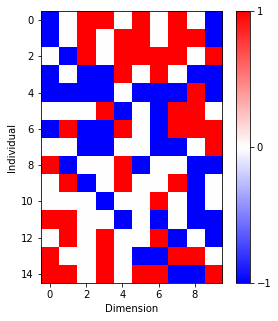

In [11]:
n_individuals = 15
beliefs = np.random.choice([-1, 0, +1], size=(n_individuals, n_dimensions))

# plot
plt.figure(figsize=(5,5))
plt.imshow(beliefs, cmap='bwr')
plt.xlabel('Dimension')
plt.ylabel('Individual')
plt.colorbar(ticks=[-1, 0, 1]);

In [12]:
heterogeneity = np.mean(np.var(beliefs, axis=0))
heterogeneity

0.60622222222222233

In [13]:
effectiveness_of_socialization = .1  # called 'p'

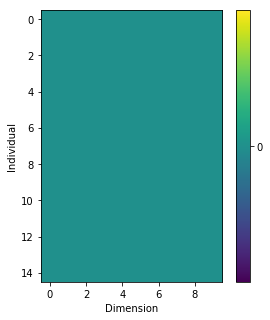

In [14]:
disagreement = (code != beliefs) & (code != 0)

# plot
plt.figure(figsize=(5,5))
plt.imshow(disagreement)
plt.xlabel('Dimension')
plt.ylabel('Individual');
plt.colorbar(ticks=[0,1]);

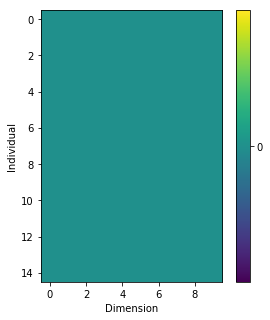

In [15]:
change = np.random.binomial(1, p=disagreement*effectiveness_of_socialization) 

# plot
plt.figure(figsize=(5,5))
plt.imshow(change)
plt.xlabel('Dimension')
plt.ylabel('Individual');
plt.colorbar(ticks=[0,1]);

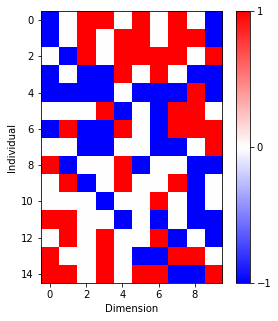

In [16]:
new_beliefs = np.where(change, code, beliefs)

# plot
plt.figure(figsize=(5,5))
plt.imshow(new_beliefs, cmap='bwr')
plt.xlabel('Dimension')
plt.ylabel('Individual')
plt.colorbar(ticks=[-1, 0, 1]);

In [17]:
def scoring(reality, knowledge):
    return np.mean(reality == knowledge, axis=1)

In [19]:
scoring(reality, beliefs)

array([ 0.3,  0.4,  0.5,  0.3,  0.2,  0.2,  0.6,  0.3,  0.3,  0.4,  0.2,
        0.4,  0.1,  0.3,  0.5])

In [20]:
scoring(reality, code)

array([ 0.])

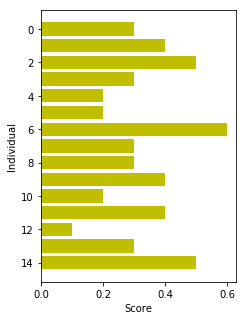

In [21]:
performers = scoring(reality, beliefs) > scoring(reality, code)

#plot
plt.figure(figsize=(3.5,5))
plt.barh(bottom=range(n_individuals), width=scoring(reality, beliefs), 
         color=['y' if p else 'k' for p in performers])
plt.gca().invert_yaxis()
plt.xlabel('Score')
plt.ylabel('Individual');

In [22]:
performers

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True], dtype=bool)

The formulation for updating the code is not clearly specified:

>If the code differs from the
majority view on a particular dimension at the start of a time period, the probability that it will be
unchanged at the end of period is (1-P)^k ,where k (k > 0) is the number of individuals (within the
superior group) who differ from the code on this dimension minus the number who do no-t.

I read 'k (k>0)' to be a bounding condition on k, such that when more people in the majority agree with the code, then adjusted net differers is 0, so that p_update will be 0.

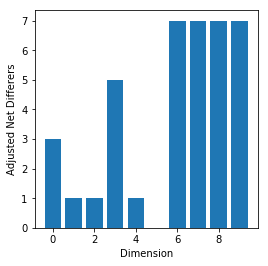

In [23]:
net_differers = (sum(beliefs[performers] != code, axis=0) - 
                 sum(beliefs[performers] == code, axis=0))  

adjusted_net_differers = np.where(net_differers>0, net_differers, 0)  # called 'k'

# plot
plt.figure(figsize=(4,4))
plt.bar(left=range(n_dimensions), height=adjusted_net_differers)
plt.xlabel('Dimension')
plt.ylabel('Adjusted Net Differers');

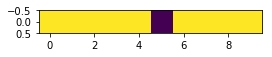

In [24]:
effectiveness_of_codification = 1  # called 'p2'
p_update = 1 - (1 - effectiveness_of_codification)**adjusted_net_differers
update = np.random.binomial(1, p=p_update, size=(1, n_dimensions))

# plot
plt.figure(figsize=(4,1))
plt.imshow(update, vmin=0, vmax=1);

Its funny that the likelihood of belief updating varies with the difference from the code, not the unanimity on a particular alternative

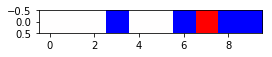

In [25]:
dominating_belief = mode(beliefs[performers]).mode

#plot
plt.figure(figsize=(4,1))
plt.imshow(dominating_belief, cmap='bwr');

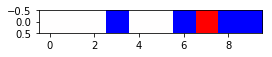

In [26]:
code = np.where(update, dominating_belief, code)

#plot
plt.figure(figsize=(4,1))
plt.imshow(code, cmap='bwr');

In [80]:
def scoring(reality, knowledge):
    return np.mean(reality == knowledge, axis=1)

def simulate(n_dimensions=10,  # Called 'm'
             effectiveness_of_codification=.1,  # called 'p2'
             n_individuals=15,
             effectiveness_of_socialization=.1,  # called 'p'
             rounds=50,
             plot_rounds=range(0,50,3),  # when should the graphs be drawn
            ):
    
    # set up initial conditions of the simulation
    reality = np.random.choice([-1, +1], size=(1, n_dimensions))
    code = np.zeros_like(reality)
    beliefs = np.random.choice([-1, 0, +1], size=(n_individuals, n_dimensions))
    code_knowledge = [scoring(reality, code)]
    mean_individual_knowledge = [np.mean(scoring(reality, beliefs))]
    heterogeneity = [np.mean(np.var(beliefs, axis=0))]

    # intial conditions for the plot
    if len(plot_rounds) > 0:
        col = 0
        colspan = n_dimensions
        shape=(7*(n_individuals+1) + 4*6, len(plot_rounds)*(n_dimensions+1))
        gs = plt.GridSpec(*shape)
        fig = plt.figure(figsize=(.1*shape[1], .1*shape[0]))
        
    for t in range(rounds):
        # stepping through the simulation
        disagreement = (code != beliefs) & (code != 0)
        change = np.random.binomial(1, p=disagreement*effectiveness_of_socialization) 
        new_beliefs = np.where(change, code, beliefs)
        performers = scoring(reality, beliefs) > scoring(reality, code)
        
        net_differers = (sum(beliefs[performers] != code, axis=0) - 
                         sum(beliefs[performers] == code, axis=0))  

        adjusted_net_differers = np.where(net_differers>0, net_differers, 0)  # called 'k'

        p_update = 1 - (1 - effectiveness_of_codification)**adjusted_net_differers
        update = np.random.binomial(1, p=p_update, size=(1, n_dimensions))
        
        if any(performers):
            dominating_belief = mode(beliefs[performers]).mode
            new_code = np.where(update, dominating_belief, code)
        else:
            dominating_belief = code
            new_code = code
        
        # track metrics
        code_knowledge.append(scoring(reality, code))
        mean_individual_knowledge.append(np.mean(scoring(reality, beliefs)))
        heterogeneity.append(np.mean(np.var(beliefs, axis=0)))

        # plotting
        if t in plot_rounds:
            row = 1
            rowspan = 2
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(reality, cmap='bwr', vmin=-1, vmax=1)
            plt.yticks([])
            plt.xticks([])
            plt.title('Round %i' % t)
            if col == 0:
                plt.ylabel('Reality')

            row += rowspan + 2
            rowspan = 2
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(code, cmap='bwr', vmin=-1, vmax=1);
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('Code\n')

            row += rowspan + 1
            rowspan = n_individuals
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(beliefs, cmap='bwr', vmin=-1, vmax=1)
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('Beliefs')

            row += rowspan + 1
            rowspan = n_individuals
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(disagreement, vmin=0, vmax=1)
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('Disagreement')

            row += rowspan + 1
            rowspan = n_individuals
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(change, vmin=0, vmax=1)
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('Change')

            row += rowspan + 1
            rowspan = n_individuals
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(new_beliefs, cmap='bwr', vmin=-1, vmax=1)
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('New Beliefs')

            row += rowspan + 1
            rowspan = n_individuals
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.barh(bottom=range(n_individuals), width=scoring(reality, beliefs), 
                     color=['y' if p else 'k' for p in performers])
            plt.gca().invert_yaxis()
            plt.xlim(0,1)
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('Score')

            row += rowspan + 1
            rowspan = n_individuals
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.bar(left=range(n_dimensions), height=adjusted_net_differers)
            plt.ylim(0,n_individuals)
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('Adjusted\nNet\nDifferers')

            row += rowspan + 2
            rowspan = 2
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(update, vmin=0, vmax=1);
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('Update')
                
            row += rowspan + 1
            rowspan = n_individuals
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(beliefs[performers], cmap='bwr', vmin=-1, vmax=1)
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('Performers\nBeliefs')

            row += rowspan + 2
            rowspan = 2
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(dominating_belief, cmap='bwr', vmin=-1, vmax=1);
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('Dominating\nBelief\n\n')
                
            row += rowspan + 2
            rowspan = 2
            plt.subplot(gs[row:row+rowspan, col:col+colspan])
            plt.imshow(new_code, cmap='bwr', vmin=-1, vmax=1);
            plt.yticks([])
            plt.xticks([])
            if col == 0:
                plt.ylabel('New\nCode')

            plt.xlabel('Dimension')
            col += colspan + 1

            
        # updating state
        beliefs = new_beliefs
        code = new_code

    return code_knowledge, mean_individual_knowledge, heterogeneity
          

# Qualitatively Exploring the Parameter Space

/Users/houghton/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


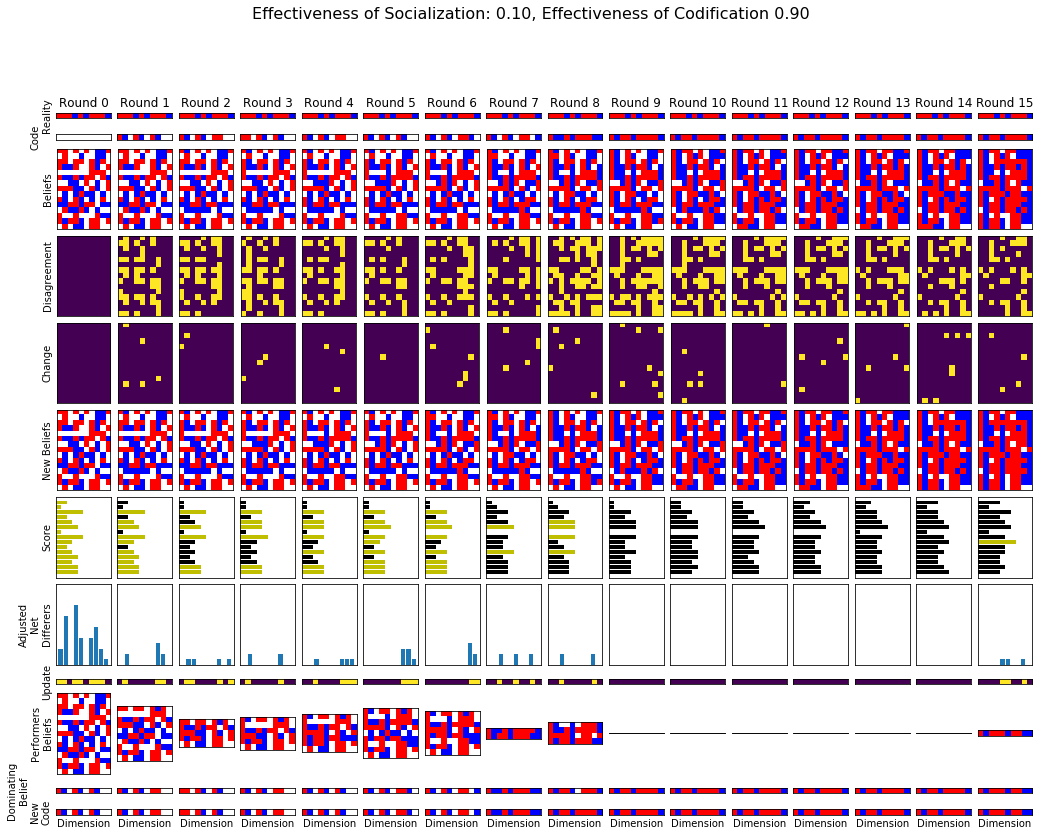

In [83]:
p1 = .1
p2 = .9
code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
    effectiveness_of_socialization=p1,
    effectiveness_of_codification=p2,
    plot_rounds=range(16),
    rounds=16)

plt.gcf().suptitle('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=16);

/Users/houghton/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


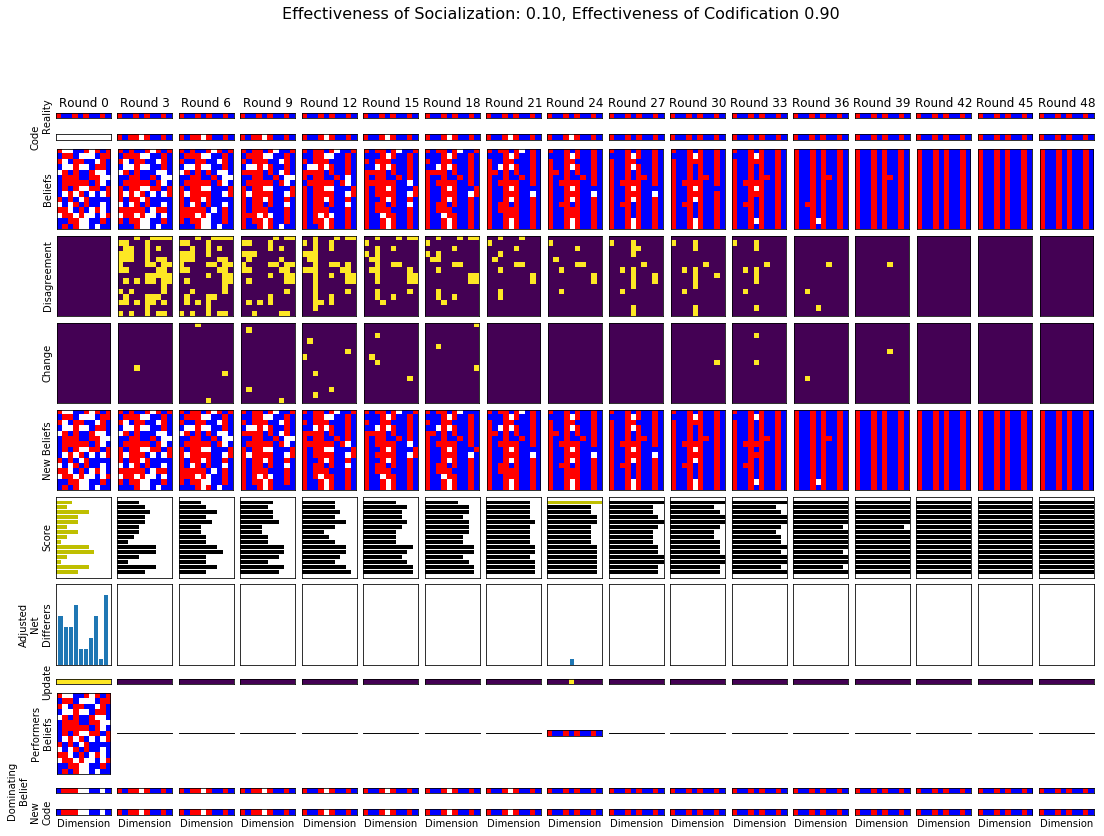

In [81]:
p1 = .1
p2 = .9
code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
    effectiveness_of_socialization=p1,
    effectiveness_of_codification=p2)

plt.gcf().suptitle('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=16);

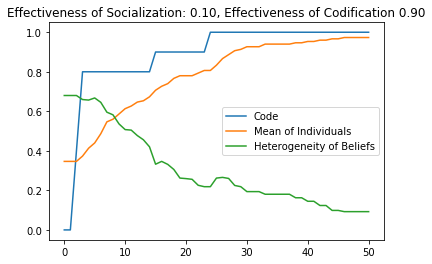

In [79]:
plt.plot(code_knowledge, label='Code')
plt.plot(mean_individual_knowledge, label='Mean of Individuals')
plt.plot(heterogeneity, label='Heterogeneity of Beliefs')
plt.legend();
plt.title('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=12);

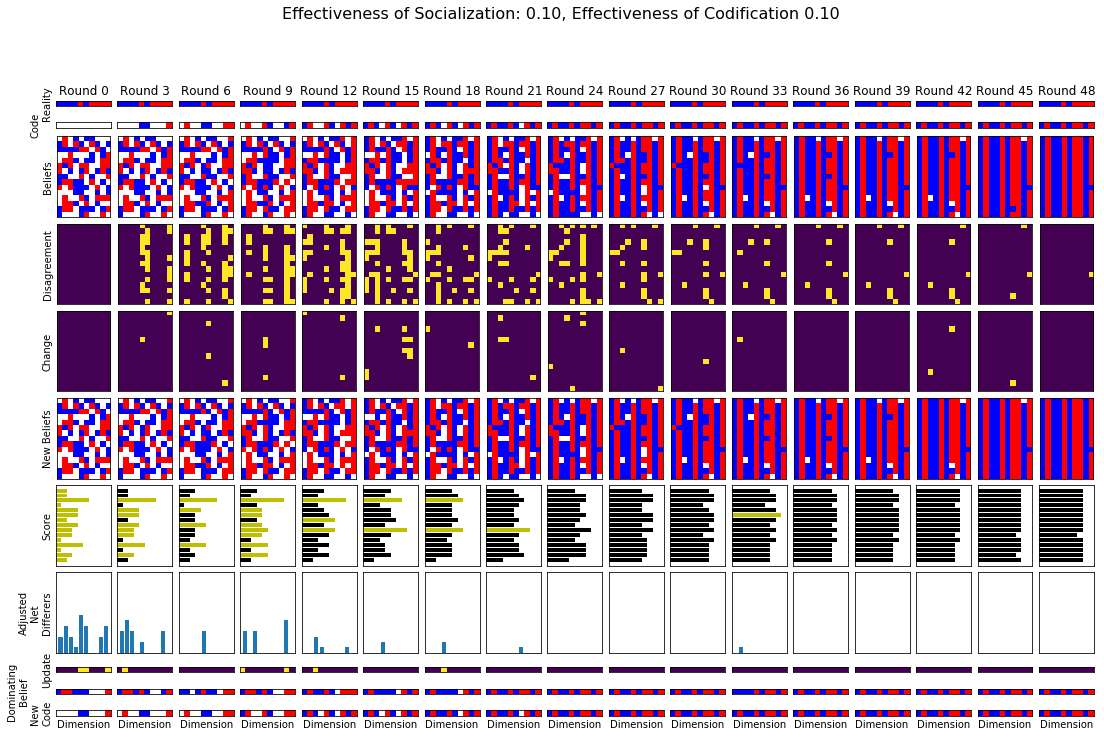

In [5]:
p1 = .1
p2 = .1
code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
    effectiveness_of_socialization=p1,
    effectiveness_of_codification=p2)

plt.gcf().suptitle('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=16);

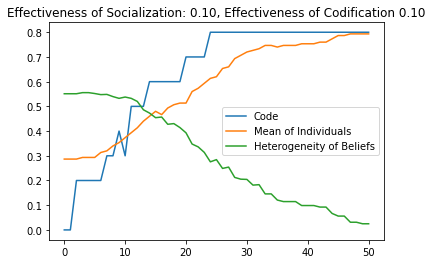

In [6]:
plt.plot(code_knowledge, label='Code')
plt.plot(mean_individual_knowledge, label='Mean of Individuals')
plt.plot(heterogeneity, label='Heterogeneity of Beliefs')
plt.legend();
plt.title('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=12);

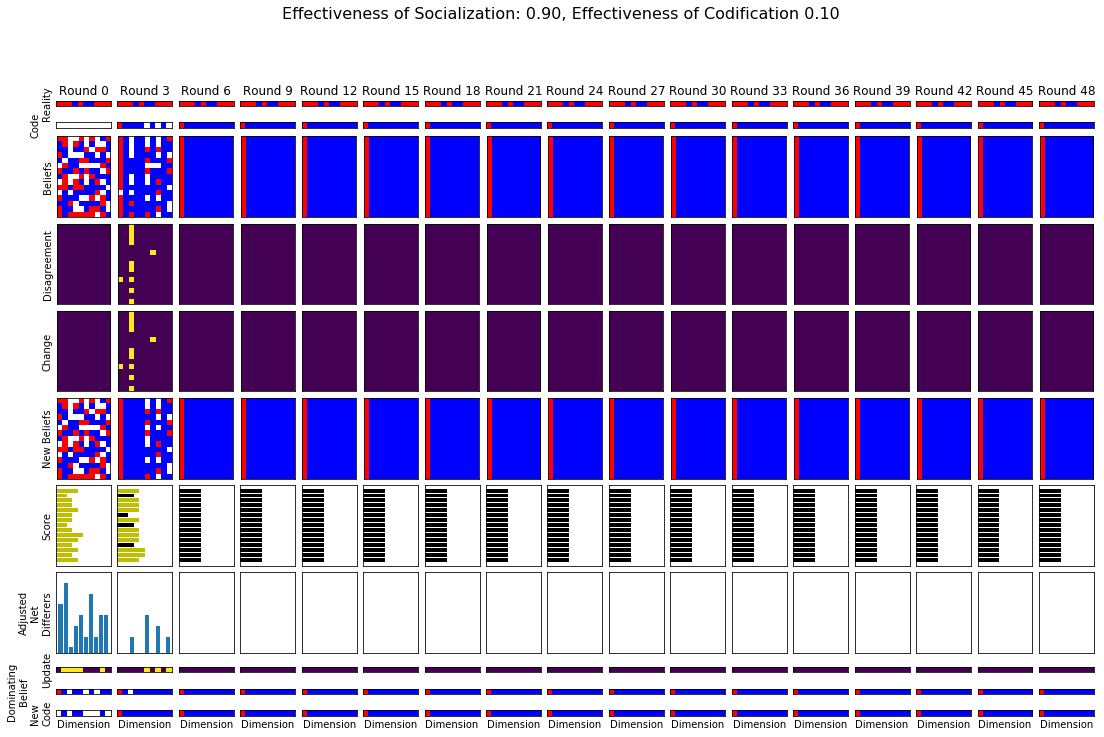

In [7]:
p1 = .9
p2 = .1
code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
    effectiveness_of_socialization=p1,
    effectiveness_of_codification=p2)

plt.gcf().suptitle('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=16);

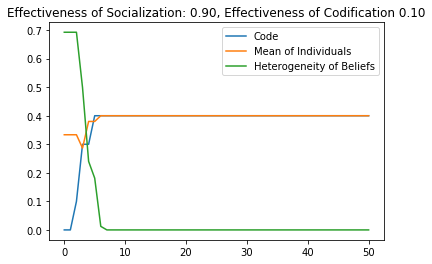

In [8]:
plt.plot(code_knowledge, label='Code')
plt.plot(mean_individual_knowledge, label='Mean of Individuals')
plt.plot(heterogeneity, label='Heterogeneity of Beliefs')
plt.legend();
plt.title('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=12);

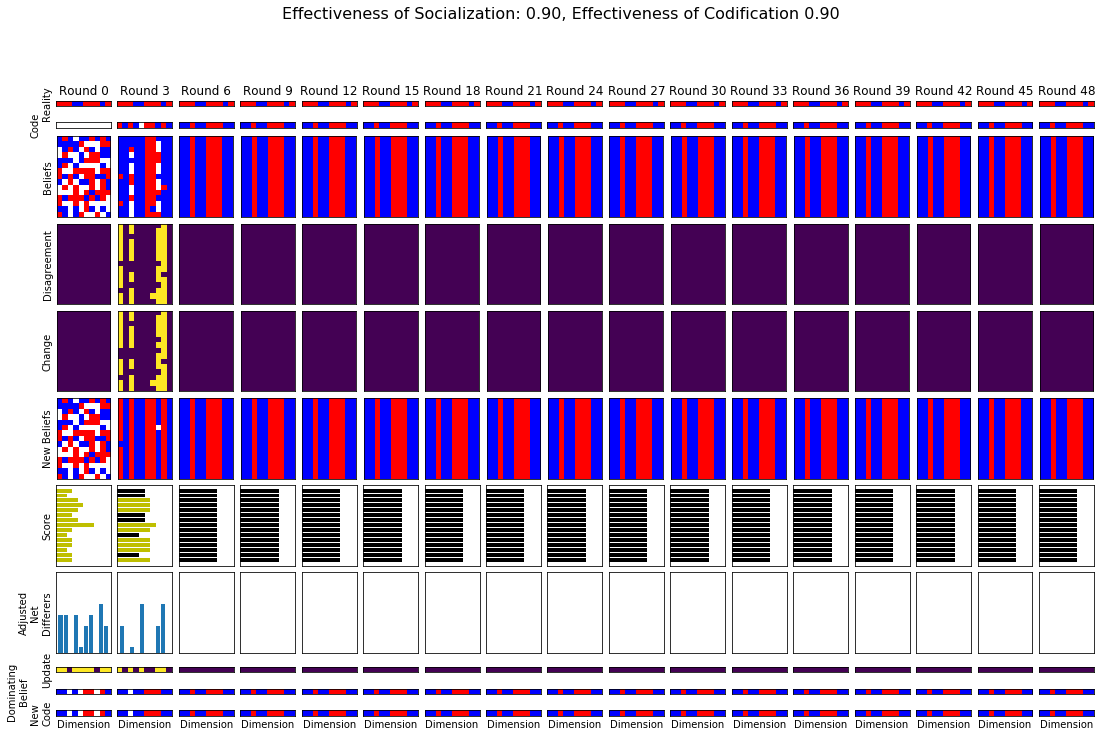

In [34]:
p1 = .9
p2 = .9
code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
    effectiveness_of_socialization=p1,
    effectiveness_of_codification=p2)

plt.gcf().suptitle('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=16);

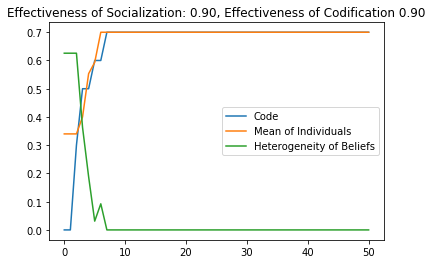

In [35]:
plt.plot(code_knowledge, label='Code')
plt.plot(mean_individual_knowledge, label='Mean of Individuals')
plt.plot(heterogeneity, label='Heterogeneity of Beliefs')
plt.legend()
plt.title('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=12);

## what does the variance look like?

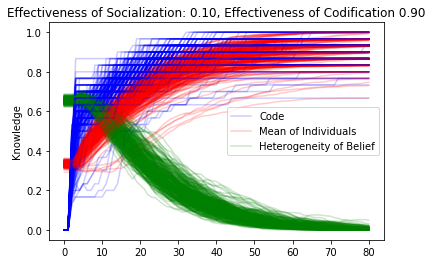

In [45]:
p1 = .1
p2 = .9
for i in range(300):
    code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
             n_dimensions=30,
             n_individuals=50,
             rounds=80,
             plot_rounds=[],
            effectiveness_of_socialization=p1,
            effectiveness_of_codification=p2)

    plt.plot(code_knowledge, color='b', alpha=.2, label='Code')
    plt.plot(mean_individual_knowledge, color='r', alpha=.2, label='Mean of Individuals')
    plt.plot(heterogeneity, color='g', alpha=.2, label='Heterogeneity of Belief')
    if i == 0:
        plt.legend()
plt.ylabel('Knowledge')
plt.title('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=12);

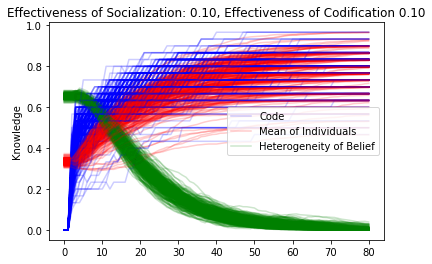

In [46]:
p1 = .1
p2 = .1
for i in range(300):
    code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
             n_dimensions=30,
             n_individuals=50,
             rounds=80,
             plot_rounds=[],
            effectiveness_of_socialization=p1,
            effectiveness_of_codification=p2)

    plt.plot(code_knowledge, color='b', alpha=.2, label='Code')
    plt.plot(mean_individual_knowledge, color='r', alpha=.2, label='Mean of Individuals')
    plt.plot(heterogeneity, color='g', alpha=.2, label='Heterogeneity of Belief')
    if i == 0:
        plt.legend()
plt.ylabel('Knowledge')
plt.title('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=12);

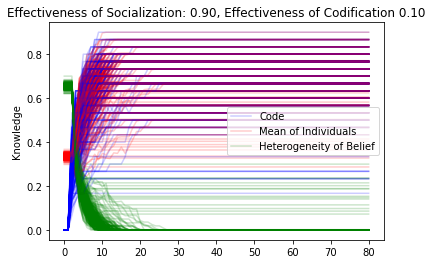

In [47]:
p1 = .9
p2 = .1
for i in range(300):
    code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
             n_dimensions=30,
             n_individuals=50,
             rounds=80,
             plot_rounds=[],
            effectiveness_of_socialization=p1,
            effectiveness_of_codification=p2)

    plt.plot(code_knowledge, color='b', alpha=.2, label='Code')
    plt.plot(mean_individual_knowledge, color='r', alpha=.2, label='Mean of Individuals')
    plt.plot(heterogeneity, color='g', alpha=.2, label='Heterogeneity of Belief')
    if i == 0:
        plt.legend()
plt.ylabel('Knowledge')
plt.title('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=12);

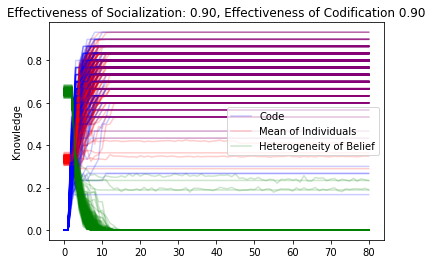

In [48]:
p1 = .9
p2 = .9
for i in range(300):
    code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
             n_dimensions=30,
             n_individuals=50,
             rounds=80,
             plot_rounds=[],
            effectiveness_of_socialization=p1,
            effectiveness_of_codification=p2)

    plt.plot(code_knowledge, color='b', alpha=.2, label='Code')
    plt.plot(mean_individual_knowledge, color='r', alpha=.2, label='Mean of Individuals')
    plt.plot(heterogeneity, color='g', alpha=.2, label='Heterogeneity of Belief')
    if i == 0:
        plt.legend()
plt.ylabel('Knowledge')
plt.title('Effectiveness of Socialization: %.02f, Effectiveness of Codification %.02f' % (p1, p2), 
                   fontsize=12);

## Response to parameters

In [30]:
@nb.vectorize([nb.float64(nb.float64, nb.float64)])
def evaluate(effectiveness_of_socialization, effectiveness_of_codification):
    n_sims=500
    final_mean_individual_knowledge = []
    final_code_knowledge = []
    for _ in range(n_sims):
        code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
                 n_dimensions=30,
                 n_individuals=50,
                 rounds=80,
                 effectiveness_of_socialization=effectiveness_of_socialization,
                 effectiveness_of_codification=effectiveness_of_codification,
                 plot_rounds=[]
        )
        final_mean_individual_knowledge.append(mean_individual_knowledge[-1])
        final_code_knowledge.append(code_knowledge[-1])
    return float(np.mean(final_mean_individual_knowledge))


In [31]:
effectiveness_of_socialization = np.arange(.1, .9, .1)
effectiveness_of_codification = np.array([0.1, 0.5, 0.9])
p1s, p2s = np.meshgrid(effectiveness_of_socialization, effectiveness_of_codification)

In [32]:
individual_knowledge = evaluate(p1s, p2s)

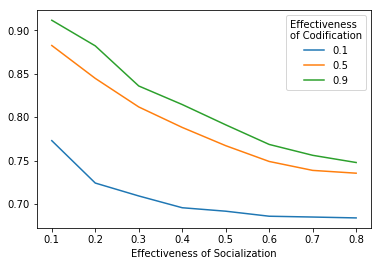

In [33]:
plt.plot(effectiveness_of_socialization, individual_knowledge.T);
plt.xlabel('Effectiveness of Socialization');
plt.legend(effectiveness_of_codification, title='Effectiveness\nof Codification');

# Heterogeneity

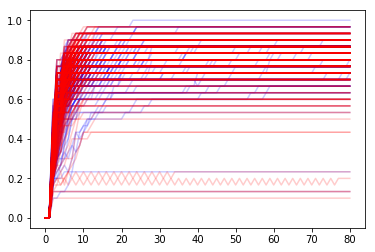

In [74]:
p1 = np.random.rand(50,1)
p2 = .9
for i in range(300):
    code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
             n_dimensions=30,
             n_individuals=50,
             rounds=80,
             plot_rounds=[],
            effectiveness_of_socialization=p1,
            effectiveness_of_codification=p2)

    plt.plot(code_knowledge, color='b', alpha=.2, label='Variance')

p1 = .5
p2 = .9
for i in range(300):
    code_knowledge, mean_individual_knowledge, heterogeneity = simulate(
             n_dimensions=30,
             n_individuals=50,
             rounds=80,
             plot_rounds=[],
            effectiveness_of_socialization=p1,
            effectiveness_of_codification=p2)

    plt.plot(code_knowledge, color='r', alpha=.2, label='None')


# todo:
1. the code starts out randomized, 
2. actions are from beliefs, zero beliefs produce randomized actions, these get copied by the code.
3. if you have a belief of +1 and the code is -1, and you learn from the code, instead of going to -1, you go to 0